In [1]:
import os
from io import BytesIO
import time
import zipfile
import numpy as np
import boto3
from tqdm import tqdm
from datetime import datetime, timezone
from time import gmtime, strftime
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sys
sys.path.append('../../../source/ServerlessAppPerfCostMdlOpt')
import networkx as nx
import itertools
import warnings
warnings.filterwarnings("ignore")
from ServerlessAppWorkflow import ServerlessAppWorkflow
from AppGenerator import AppGenerator
from PerfOpt import PerfOpt

# Read Results from Apps

In [2]:
app_list = ['App'+str(i) for i in range(8, 18, 2)]

In [3]:
results = {}
app_duration_aws_trimmed_dict = {}
app_cost_aws_trimmed_dict = {}
for app in app_list:
    with open('../'+app+'/results.json', 'r') as f:
        results[app] = json.load(f)
    app_duration_aws_trimmed_dict[app] = np.array(pd.read_csv('../{}/{}_Duration_AWS.csv'.format(app, app), error_bad_lines=False, warn_bad_lines=False, low_memory=False, index_col=0)['Duration'])
    app_cost_aws_trimmed_dict[app] = np.array(pd.read_csv('../{}/{}_Cost_AWS.csv'.format(app, app), error_bad_lines=False, warn_bad_lines=False, low_memory=False, index_col=0)['1M_Exe_Cost'])

# Analytical Model Accuracy

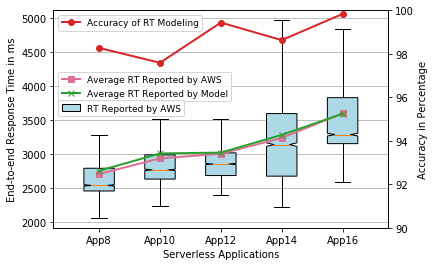

In [4]:
labels = app_list
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
position_list = list(range(0, len(app_list)))
ax2 = ax.twinx()
bplot = ax.boxplot(app_duration_aws_trimmed_dict.values(),
                         notch=True,
                         vert=True,
                         patch_artist=True,
                         showfliers=False,
                         positions=position_list,
                         labels=labels, zorder=10)

avg_rt_line = ax.plot(position_list,  [np.mean(app_duration_aws_trimmed_dict[app]) for app in app_list], linewidth=2, color='palevioletred', marker='s', markeredgecolor='palevioletred', zorder=20, label='Average RT Reported by AWS')
model_rt_line = ax.plot(position_list, [results[app]['RT_Model'] for app in app_list], linewidth=2, color='tab:green', marker='x', markeredgecolor='tab:green', zorder=30, label='Average RT Reported by Model')
accuracy_line = ax2.plot(position_list, [results[app]['RT_Accuracy'] for app in app_list], linewidth=2, color='tab:red', marker='o', markeredgecolor='tab:red', zorder=30, label='Accuracy of RT Modeling')
for patch in bplot['boxes']:
    patch.set_facecolor('lightblue')
    
ax2.set_ylim(90, 100)
ax.yaxis.grid(True)
ax_legend1 = ax.legend(loc='center left', bbox_to_anchor=(0,0.65),  prop={'size': 9})
ax_legend2 = ax.legend([bplot["boxes"][0]], ['RT Reported by AWS'], loc='center left', bbox_to_anchor=(0,0.55),  prop={'size': 9})
ax.add_artist(ax_legend1)
ax2.legend(loc='upper left',  prop={'size': 9})
ax.set_xlabel('Serverless Applications')
ax.set_ylabel('End-to-end Response Time in ms')
ax2.set_ylabel('Accuracy in Percentage')
plt.show()
fig.savefig('Analytical_Model_Accuracy_RT', dpi=300)
fig.savefig('Analytical_Model_Accuracy_RT.pdf')

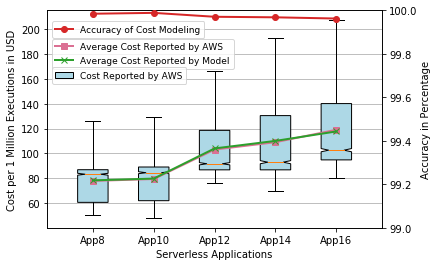

In [5]:
labels = app_list
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
position_list = list(range(0, len(app_list)))
ax2 = ax.twinx()
bplot = ax.boxplot(app_cost_aws_trimmed_dict.values(),
                         notch=True,
                         vert=True,
                         patch_artist=True,
                         showfliers=False,
                         positions=position_list,
                         labels=labels, zorder=10)

avg_cost_line = ax.plot(position_list,  [np.mean(app_cost_aws_trimmed_dict[app]) for app in app_list], linewidth=2, color='palevioletred', marker='s', markeredgecolor='palevioletred', zorder=20, label='Average Cost Reported by AWS')
model_cost_line = ax.plot(position_list, [results[app]['Cost_Model'] for app in app_list], linewidth=2, color='tab:green', marker='x', markeredgecolor='tab:green', zorder=30, label='Average Cost Reported by Model')
accuracy_line = ax2.plot(position_list, [results[app]['Cost_Accuracy'] for app in app_list], linewidth=2, color='tab:red', marker='o', markeredgecolor='tab:red', zorder=30, label='Accuracy of Cost Modeling')
for patch in bplot['boxes']:
    patch.set_facecolor('lightblue')
    
ax2.set_ylim(99, 100)
ax.yaxis.grid(True)
ax_legend1 = ax.legend(loc='center left', bbox_to_anchor=(0,0.8),  prop={'size': 9})
ax_legend2 = ax.legend([bplot["boxes"][0]], ['Cost Reported by AWS'], loc='center left', bbox_to_anchor=(0,0.7),  prop={'size': 9})
ax.add_artist(ax_legend1)
ax2.legend(loc='upper left', bbox_to_anchor=(0,0.97),  prop={'size': 9})
ax.set_xlabel('Serverless Applications')
ax.set_ylabel('Cost per 1 Million Executions in USD')
ax2.set_ylabel('Accuracy in Percentage')
plt.show()
fig.tight_layout()
fig.savefig('Analytical_Model_Accuracy_Cost', dpi=300)
fig.savefig('Analytical_Model_Accuracy_Cost.pdf')